In [8]:
# Core imports
import numpy as np
import pandas as pd

# Pre-processing imports
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer

import spacy

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

# Model-building imports
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

# BOW
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Word embedding imports
import gensim
from gensim.models import Word2Vec

# Visualize
import seaborn as sns
from tqdm.notebook import tqdm_notebook

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\atabekis\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\atabekis\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\atabekis\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Reading the dataset and splitting into train and test

In [9]:
df = pd.read_csv('data/cleaned_extrovert.csv', engine='pyarrow')

## EDA on the data

Class distributions -> imbalanced data
We can clearly see that there are more introvert classification compared to extrovert classification
-> do some reading on SMOTE

<Axes: xlabel='label', ylabel='count'>

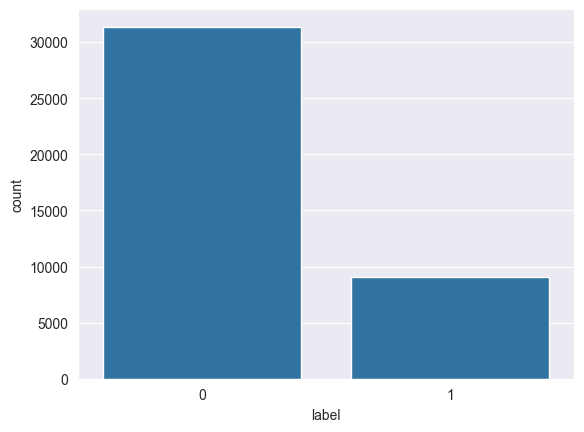

In [10]:
label_counts = df['label'].value_counts()
sns.barplot(label_counts)

Check for the number of characters in a user's posts -> number of words wont work because the data we have is split by 1500 space-separated entries
We don't see a big difference between the two:
introverted: 5575 chars
extroverted: 5693 chars

In [11]:
df['char_count'] = df['post'].apply(lambda x: len(str(x)))
print(df[df['label']==1]['char_count'].mean())
print(df[df['label']==0]['char_count'].mean())

5693.471922484035
5575.267197959834


## Vectorization

In [12]:
x_train, x_test, y_train, y_test = train_test_split(df['post'], df['label'], test_size=0.2, shuffle=True, random_state=5)
# Random state = 5 because I want reproducibility in the .npy files

Word2Vec

In [24]:
def tokenize_pbar(data):
    tokenized_pbar = tqdm_notebook(data, desc="Tokenizing sentences", unit="sentence")
    out = [nltk.word_tokenize(sentence) for sentence in tokenized_pbar]
    tokenized_pbar.close()
    return out

The cell below takes approximately 7-8 minutes to execute, set run=False to load from saved tokenized arrays -> this is the reason we're using random state = 5 in train test split.

In [27]:
run = False
if run:
    x_train_tok = tokenize_pbar(x_train)
    x_test_tok = tokenize_pbar(x_test)
    
    x_train_tok_array = np.asarray(x_train_tok, dtype='object') # Numpy was having issues with converting,
    x_test_tok_array = np.asarray(x_test_tok, dtype='object') # Therefore, we force object dtype
    
    np.save('data/arrays/tokens_train.npy', x_train_tok_array)
    np.save('data/arrays/tokens_test.npy', x_test_tok_array)
else:
    x_train_tok = np.load('data/arrays/tokens_train.npy', allow_pickle=True)
    x_test_tok = np.load('data/arrays/tokens_test.npy', allow_pickle=True)

Tf*iDf

In [33]:
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
x_train_vectors_tfidf = tfidf_vectorizer.fit_transform(x_train)
x_test_vectors_tfidf = tfidf_vectorizer.transform(x_test)

Word2Vec model

In [42]:
class MeanEmbeddingVectorizer:
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(next(iter(word2vec.values())))
        
    def fit(self, X, y):
        return self
    
    def transform(self, X):
        
        transform_pbar = tqdm_notebook(X, desc="Transforming into vectors", unit="token")
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec] or [np.zeros(self.dim)], axis=0)
            for words in transform_pbar
        ])


In [35]:
df['tokens'] = tokenize_pbar(df['post'])
df.head()

Tokenizing sentences:   0%|          | 0/40452 [00:00<?, ?sentence/s]

,author_id,post,label,char_count,tokens
0,t2_2hrxxs28,"question, doctor, how'd get painkillers? otc p...",0,5361,"[question, ,, doctor, ,, how, 'd, get, painkil..."
1,t2_2hrxxs28,butt covid + cycle. i'm sure what's going i've...,0,5444,"[butt, covid, +, cycle, ., i, 'm, sure, what, ..."
2,t2_2hrxxs28,different doctors. situation sucks relate peop...,0,5197,"[different, doctors, ., situation, sucks, rela..."
3,t2_4pxpgwz,thought pebbleyeet guy autistic guy wants “fix...,0,6211,"[thought, pebbleyeet, guy, autistic, guy, want..."
4,t2_4pxpgwz,…i always end voting wrong even crewmate. hour...,0,5565,"[…i, always, end, voting, wrong, even, crewmat..."


running the code below takes a long time
TODO: model.save()

In [36]:
model = Word2Vec(df['tokens'], min_count=1) 
w2v = dict(zip(model.wv.index_to_key, model.wv.vectors))

In [41]:
model_w = MeanEmbeddingVectorizer(w2v)
x_train_vectors_w2v = model_w.transform(x_train_tok)
x_test_vectors_w2v = model_w.transform(x_test_tok)

Tokenizing sentences:   0%|          | 0/32361 [00:00<?, ?sentence/s]

Tokenizing sentences:   0%|          | 0/8091 [00:00<?, ?sentence/s]

# We're ready to do some ML :)

### Logistic Regression -- tf*idf

In [44]:
lr_tfidf = LogisticRegression(solver='liblinear', C=10, penalty='l2')
lr_tfidf.fit(x_train_vectors_tfidf, y_train)

LogisticRegression(C=10, solver='liblinear')

In [57]:
y_predict = lr_tfidf.predict(x_test_vectors_tfidf)
y_prob = lr_tfidf.predict_proba(x_test_vectors_tfidf)[:,1]

In [65]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.90      0.97      0.94      6252
           1       0.88      0.64      0.74      1839

    accuracy                           0.90      8091
   macro avg       0.89      0.81      0.84      8091
weighted avg       0.90      0.90      0.89      8091


In [66]:
confusion_matrix(y_test, y_predict)

array([[6088,  164],
       [ 663, 1176]], dtype=int64)

In [67]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

AUC: 0.9346415563550386


### Logistic Regression -- Word2Vec

In [68]:
lr_w2v = LogisticRegression(solver='liblinear', C=10, penalty='l2')
lr_w2v.fit(x_train_vectors_w2v, y_train)

LogisticRegression(C=10, solver='liblinear')

In [69]:
y_predict = lr_w2v.predict(x_test_vectors_w2v)
y_prob = lr_w2v.predict_proba(x_test_vectors_w2v)[:,1]

In [72]:
print(classification_report(y_test,y_predict))
print('Confusion Matrix: \n',confusion_matrix(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.79      0.98      0.88      6252
           1       0.64      0.14      0.23      1839

    accuracy                           0.79      8091
   macro avg       0.72      0.56      0.55      8091
weighted avg       0.76      0.79      0.73      8091

Confusion Matrix: 
 [[6106  146]
 [1580  259]]


In [73]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

AUC: 0.7167105547431999
